# README

This is the COFFEE algorithm we have using the biexponential model for 6 parameters; however, this model doesn't rely on the BIC filter but rather uses pre-determined moX and biX environments

Steps:
    1. Each curve is pre-evaluated as biexponential or monoexponential
    2. We first take the data, fit it twice to the biexponential model with unique initial starting locations with scipy.curve_fit
    3. We use the estimated parameters from curve_fit as new initial conditions in the new moX vs. biX objective function



We are playing with code that would take data from the brain and assess if each point is MoX or BiX. The objective function used to select parameters will then ensure that the MoX points are fit with the MoX function while the biX points are fit with the biX function. This file looks at the 6p model across a log scale of TI value 

# Libraries

In [17]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
from matplotlib.lines import Line2D

# Initialize Parameters

In [18]:
####### Options #######
randStart = True                  #Initial guess for parameter values in random locations

In [19]:
######All Fixed parameters for code
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.4
c2 = 0.6 
T21 = 40
T22 = 60

true_params = np.array([T11, T12, c1, c2, T21, T22])

#Building the TE array - this should be a uniform array
n_points = 64
TE_step = 8

TE_DATA = np.linspace(TE_step, TE_step*n_points, n_points) #ms units

assert(TE_DATA[-1] == 512)
d_TE = np.mean(np.diff(TE_DATA))
assert(d_TE == 8)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12


######### TI list of points used in the final evaluation
TI_STANDARD = np.append(0,np.logspace(1,np.log10(3*T12),11))//1
index_TI1star = np.argmin((TI_STANDARD - TI1star)**2)
index_TI2star = np.argmin((TI_STANDARD - TI2star)**2)
TI_NP = np.append(0,np.logspace(1,np.log10(3*T12),11))//1
TI_NP[index_TI1star] = TI1star//1 + 30
TI_NP[index_TI2star] = TI2star//1 + 30

Exp_STANDARD = np.zeros(len(TI_STANDARD))
Exp_NP = np.zeros(len(TI_NP))
Exp_NP[index_TI1star] = 1
Exp_NP[index_TI2star] = 1

Exponential_labels = ['BiX', 'MoX']
Exp_label_NP = [Exponential_labels[int(elem)] for elem in Exp_NP]
Exp_label_STANDARD = [Exponential_labels[int(elem)] for elem in Exp_STANDARD]

#SNR Value to Evaluate
SNR_STANDARD = 100
SNR_NP = SNR_STANDARD*(np.sum(TI_STANDARD)/np.sum(TI_NP))**(1/2)

#Parameters that dictate process related features
var_reps = 1000          #number of times we iterate the full test

if randStart:
    multi_starts_obj = 2
else:
    multi_starts_obj = 1
  

#Builds a string of parameters to use in the titles
ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']
round_Params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

#### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [20]:
#Defining the function of interest

def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def S_moX_3p(TE, T1, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

In [21]:
def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (2, 2, 0, 0, 2, 2)
        upper_bound = (2000, 2000, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (2, 0, 2)
        upper_bound = (2000, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 2, 2)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 2)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("T21","T22","c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("T21","c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        # f_name = func.__name__
        # if f_name.find("moX") > -1:
        #     p0 = [75, 0.5, 75]
        # elif f_name.find("biX") > -1:
        #     p0 = [75, 75, 0.5, 0.5, 75, 75]
        # else:
        p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def bounds_condensed(lb, ub):
    lb, ub = get_func_bounds(S_biX_6p)
    bnd_cat = [lb,ub]
    bnd_cat = np.array(bnd_cat)
    bnd_cat = np.transpose(bnd_cat)
    bnds = bnd_cat.tolist()
    return bnds



In [22]:
def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def calculate_RSS(func, popt, data):
    est_curve = func(TE_DATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore, axis=0)
    biMat = np.mean(paramStore, axis = 0) - true_params  #E[p_hat] - p_true
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, varMat, biMat

In [23]:
def list_objective_func(param_est, data_2d, TI_array, X_list):
    assert(data_2d.shape[0] == len(TI_array))
    assert(len(X_list) == len(TI_array))

    curve_RSS = 0

    X_truth = [elem == "BiX" for elem in X_list]

    for iter in range(len(X_truth)):
        if X_truth[iter]:
            RSS_add = calculate_RSS_TI(S_biX_6p, param_est, TI_array[iter], data_2d[iter,:])
        else:
            if data_2d[iter,0] < 0:
                #first null point -> that means that only the long parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-5], param_est[-3], param_est[-1]], TI_array[iter], data_2d[iter,:])
            else:
                #second null point -> that means that only the short parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-6], param_est[-4], param_est[-2]], TI_array[iter], data_2d[iter,:])

        curve_RSS += RSS_add

    return curve_RSS



In [24]:
def estP_oneCurve(func, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, noisey_data)

    return popt, RSS

def preEstimate_parameters(TE_DATA, TI_DATA, noised_data, lb, ub):

    mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)
    vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points

    cF_fval = np.inf

    no_opt_found = 0

    for ms_iter in range(multi_starts_obj):
        init_p = set_p0(S_biX_6p, random = randStart)

        try:
            vecS = noised_data.ravel()
            popt_temp, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 5000)
            RSS_cF_array = []
            for iter in range(noised_data.shape[0]):
                RSS_cF_array.append(calculate_RSS_TI(S_biX_6p, popt_temp, TI_DATA[iter], noised_data[iter,:]))
            RSS_cF_temp = np.sum(RSS_cF_array)
            if RSS_cF_temp < cF_fval:
                popt = popt_temp
                RSS_cF = RSS_cF_temp
                cF_fval = RSS_cF_temp
        except:
            no_opt_found+=1

    #This is the failsafe to ensure that some parameters are found
    if no_opt_found == multi_starts_obj:
        print("Overtime")
        while no_opt_found > 0:
            init_p = set_p0(S_biX_6p, random = randStart)
            try:
                vecS = noised_data.ravel()
                popt_temp, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 5000)
                RSS_cF_array = []
                for iter in range(noised_data.shape[0]):
                    RSS_cF_array.append(calculate_RSS_TI(S_biX_6p, popt_temp, TI_DATA[iter], noised_data[iter,:]))
                RSS_cF_temp = np.sum(RSS_cF_array)
                if RSS_cF_temp < cF_fval:
                    popt = popt_temp
                    RSS_cF = RSS_cF_temp
                    cF_fval = RSS_cF_temp
                no_opt_found = 0
            except:
                no_opt_found = 1

    return check_param_order(popt)

def estimate_parameters(popt, TI_DATA, noised_data, lb, ub, list_curve_X, list_curve_cvn):

    bnds = bounds_condensed(lb, ub)

    res_AIC = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_X), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})
    res_cvn = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_cvn), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})

    #Pulling relevant AIC objective function parts
    param_est_AIC = check_param_order(res_AIC.x)
    #Pulling relevant cvn objective function parts
    param_est_cvn = check_param_order(res_cvn.x)

    return param_est_AIC, param_est_cvn

# Iterative Fitting

In [25]:
signal_array_SR = np.zeros([len(TI_STANDARD), len(TE_DATA)])

for iTI in range(len(TI_STANDARD)):
    signal_array_SR[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_STANDARD[iTI])

In [26]:
cvn_logspaced_params = np.zeros((var_reps, len(true_params)))

lb, ub = get_func_bounds(S_biX_6p)

for rep in trange(var_reps):

    noised_data_SR = add_noise(signal_array_SR, SNR_STANDARD)

    cvn_logspaced_params[rep,:] = preEstimate_parameters(TE_DATA, TI_STANDARD, noised_data_SR, lb, ub)

    

100%|██████████| 1000/1000 [01:07<00:00, 14.77it/s]


In [27]:
signal_array_NP = np.zeros([len(TI_NP), len(TE_DATA)])

for iTI in range(len(TI_NP)):
    signal_array_NP[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_NP[iTI])

In [28]:
NP_cvn = np.zeros((var_reps, len(true_params)))
NP_COFFEE = np.zeros((var_reps, len(true_params)))
NP_cvn2 = np.zeros((var_reps, len(true_params)))

lb, ub = get_func_bounds(S_biX_6p)

for rep in trange(var_reps):

    noised_data_NP = add_noise(signal_array_NP, SNR_NP)

    NP_cvn[rep,:] = preEstimate_parameters(TE_DATA, TI_NP, noised_data_NP, lb, ub)
    NP_COFFEE[rep,:], NP_cvn2[rep,:] = estimate_parameters(NP_cvn[rep,:], TI_NP, noised_data_NP, lb, ub, Exp_label_NP, Exp_label_STANDARD)
    


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


### Presentation Figures

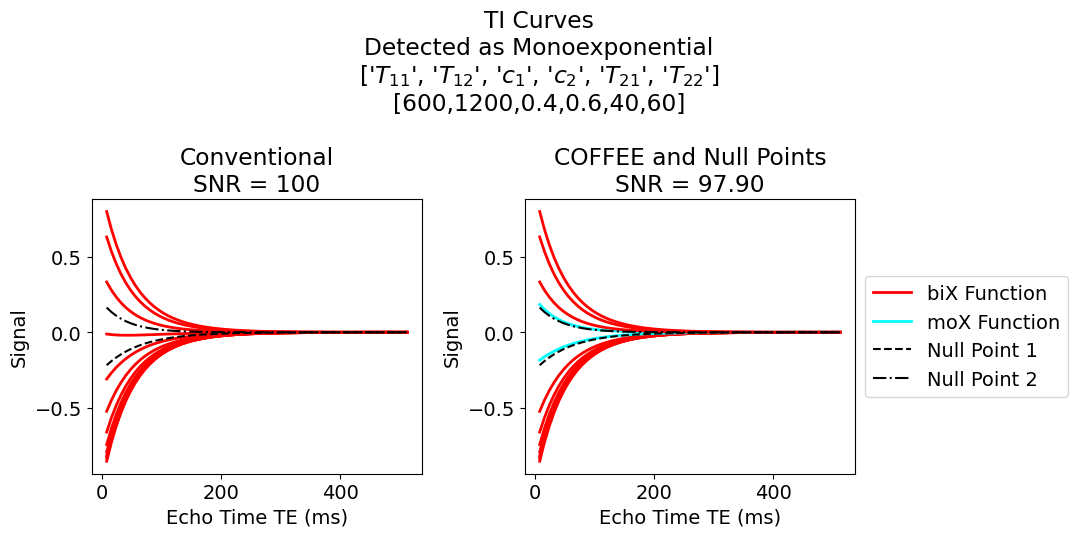

In [29]:
fig, ax = plt.subplots(1,2, figsize=(11,5.5), tight_layout=True)
fig.suptitle(f"TI Curves\nDetected as Monoexponential\n{ParamTitle_6p}\n[{T11},{T12},{c1},{c2},{T21},{T22}]")

color_mat = ['red','cyan']
label_mat = ['biX Function', 'moX Function']

for iter in range(len(TI_STANDARD)):
    ax[0].plot(TE_DATA, signal_array_SR[iter,:], lw = 2, color = color_mat[int(Exp_STANDARD[iter])])

ax[0].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI1star), color = 'k', label = 'Null Point 1', lw = 1.5, ls = '--')
ax[0].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI2star), color = 'k', label = 'Null Point 2', lw = 1.5, ls = '-.')

ax[0].set_xlabel('Echo Time TE (ms)')
ax[0].set_ylabel('Signal')
ax[0].set_title(f'Conventional\nSNR = {SNR_STANDARD}')

for iter in range(len(TI_NP)):
    ax[1].plot(TE_DATA, signal_array_NP[iter,:], lw = 2, color = color_mat[int(Exp_NP[iter])], label = label_mat[int(Exp_NP[iter])])

ax[1].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI1star), color = 'k', label = 'Null Point 1', lw = 1.5, ls = '--')
ax[1].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI2star), color = 'k', label = 'Null Point 2', lw = 1.5, ls = '-.')

ax[1].set_xlabel('Echo Time TE (ms)')
ax[1].set_ylabel('Signal')
ax[1].set_title(f'COFFEE and Null Points\nSNR = {SNR_NP:0.2f}')

hdls, lbls = ax[1].get_legend_handles_labels()
by_label = dict(zip(lbls, hdls))

ax[1].legend(handles = by_label.values(), labels = by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

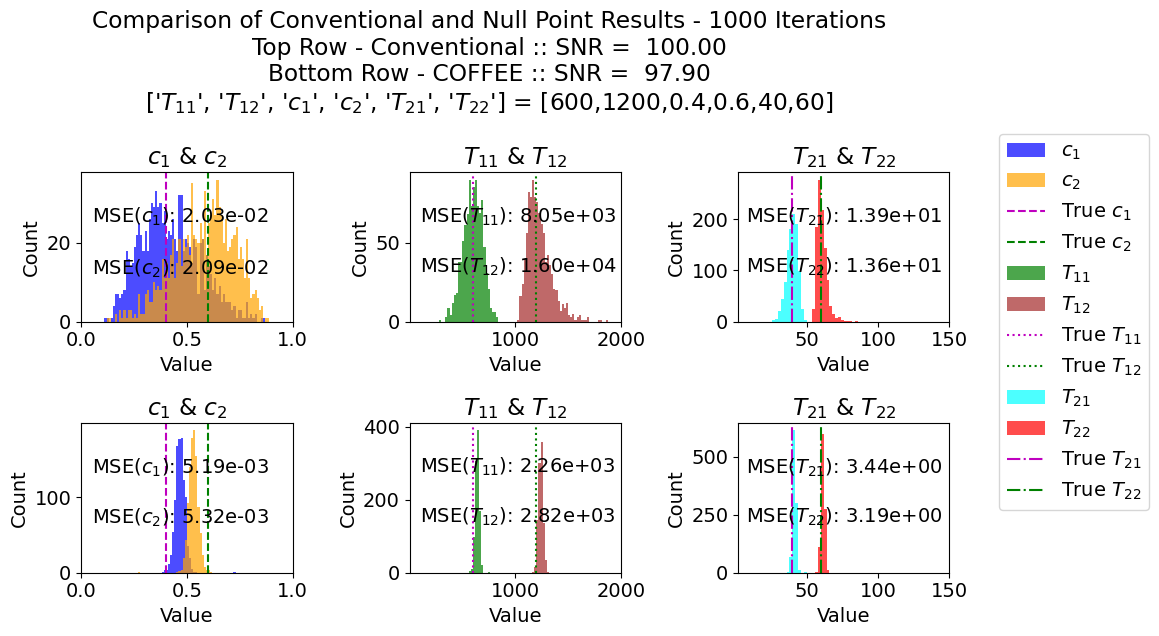

In [30]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
fig.suptitle(f"Comparison of Conventional and Null Point Results - {var_reps} Iterations\nTop Row - Conventional :: SNR = {SNR_STANDARD : 0.2f}\nBottom Row - COFFEE :: SNR = {SNR_NP : 0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(cvn_logspaced_params, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[0,0].hist(x=cvn_logspaced_params[:,-4], bins=bin_array, color='b', alpha = 0.7)
ax[0,0].hist(x=cvn_logspaced_params[:,-3], bins=bin_array, color='orange', alpha = 0.7)
ax[0,0].axvline(x = true_params[-4], color='m', ls = '--')
ax[0,0].axvline(x = true_params[-3], color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[0,0].set_xlim([lb[-3],ub[-3]])
ymin, ymax = ax[0,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
ax[0,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[1], 20)
ax[0,1].hist(x=cvn_logspaced_params[:,0], bins=bin_array, color='g', alpha = 0.7)
ax[0,1].hist(x=cvn_logspaced_params[:,1], bins=bin_array, color='brown', alpha = 0.7)
ax[0,1].axvline(x = true_params[0], color='m', ls = ':')
ax[0,1].axvline(x = true_params[1], color='g', ls = ':')
ax[0,1].set_xlabel('Value')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
ax[0,1].set_xlim([lb[0],ub[0]])
ymin, ymax = ax[0,1].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
ax[0,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[-1], 2)
ax[0,2].hist(x=cvn_logspaced_params[:,-2], bins=bin_array, color='cyan', alpha = 0.7)
ax[0,2].hist(x=cvn_logspaced_params[:,-1], bins=bin_array, color='red', alpha = 0.7)
ax[0,2].axvline(x = true_params[-2], color='m', ls = '-.')
ax[0,2].axvline(x = true_params[-1], color='g', ls = '-.')
ax[0,2].set_xlabel('Value')
ax[0,2].set_ylabel('Count')
ax[0,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
ax[0,2].set_xlim([lb[-1],ub[-1]])
ymin, ymax = ax[0,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
ax[0,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')


MSEMat, varMat, sqBMat = calc_MSE(NP_COFFEE, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=NP_COFFEE[:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=NP_COFFEE[:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[1,0].set_xlim([lb[-3],ub[-3]])
ymin, ymax = ax[1,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
ax[1,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[1], 20)
ax[1,1].hist(x=NP_COFFEE[:,0], bins=bin_array, color='g', label = r'$T_{11}$', alpha = 0.7)
ax[1,1].hist(x=NP_COFFEE[:,1], bins=bin_array, color='brown', label = r'$T_{12}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
ax[1,1].set_xlim([lb[0],ub[0]])
ymin, ymax = ax[1,1].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
ax[1,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[-1], 2)
ax[1,2].hist(x=NP_COFFEE[:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,2].hist(x=NP_COFFEE[:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,2].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = '-.')
ax[1,2].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = '-.')
ax[1,2].set_xlabel('Value')
ax[1,2].set_ylabel('Count')
ax[1,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
ax[1,2].set_xlim([lb[-1],ub[-1]])
ymin, ymax = ax[1,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
ax[1,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

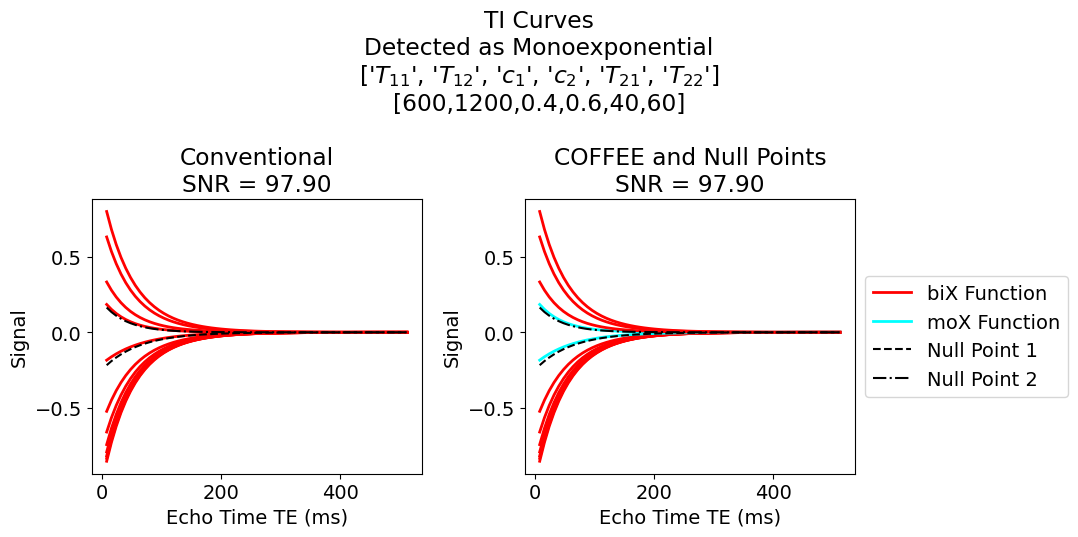

In [31]:
fig, ax = plt.subplots(1,2, figsize=(11,5.5), tight_layout=True)
fig.suptitle(f"TI Curves\nDetected as Monoexponential\n{ParamTitle_6p}\n[{T11},{T12},{c1},{c2},{T21},{T22}]")

color_mat = ['red','cyan']
label_mat = ['biX Function', 'moX Function']

for iter in range(len(TI_STANDARD)):
    ax[0].plot(TE_DATA, signal_array_NP[iter,:], lw = 2, color = color_mat[int(Exp_STANDARD[iter])])

ax[0].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI1star), color = 'k', label = 'Null Point 1', lw = 1.5, ls = '--')
ax[0].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI2star), color = 'k', label = 'Null Point 2', lw = 1.5, ls = '-.')

ax[0].set_xlabel('Echo Time TE (ms)')
ax[0].set_ylabel('Signal')
ax[0].set_title(f'Conventional\nSNR = {SNR_NP:0.2f}')

for iter in range(len(TI_NP)):
    ax[1].plot(TE_DATA, signal_array_NP[iter,:], lw = 2, color = color_mat[int(Exp_NP[iter])], label = label_mat[int(Exp_NP[iter])])

ax[1].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI1star), color = 'k', label = 'Null Point 1', lw = 1.5, ls = '--')
ax[1].plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI2star), color = 'k', label = 'Null Point 2', lw = 1.5, ls = '-.')

ax[1].set_xlabel('Echo Time TE (ms)')
ax[1].set_ylabel('Signal')
ax[1].set_title(f'COFFEE and Null Points\nSNR = {SNR_NP:0.2f}')

hdls, lbls = ax[1].get_legend_handles_labels()
by_label = dict(zip(lbls, hdls))

ax[1].legend(handles = by_label.values(), labels = by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

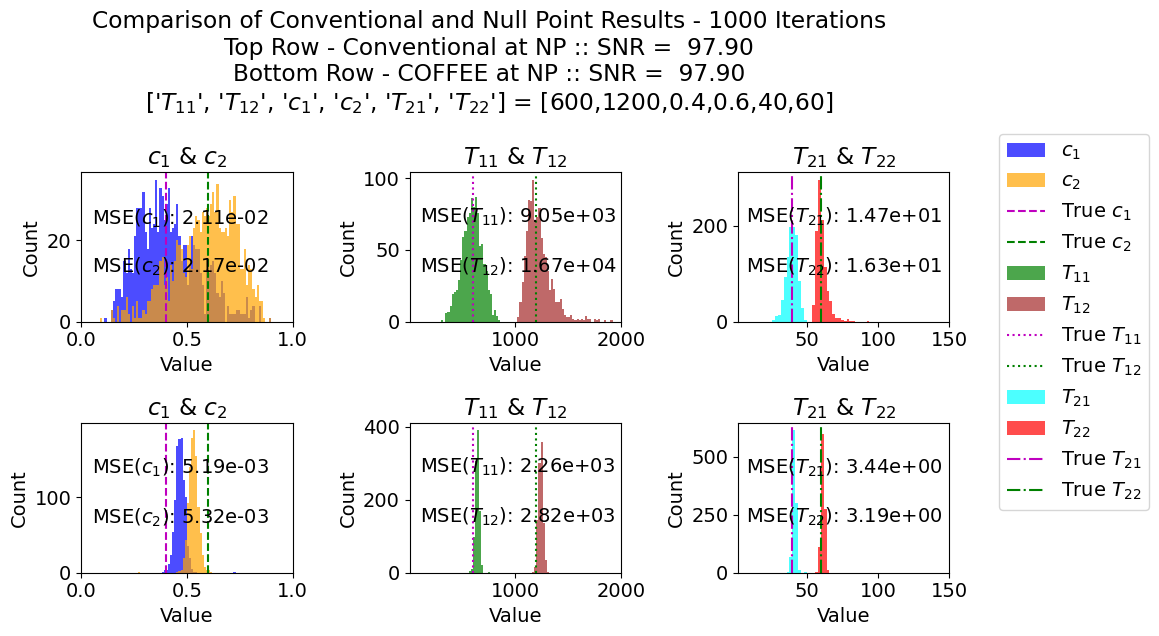

In [32]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
fig.suptitle(f"Comparison of Conventional and Null Point Results - {var_reps} Iterations\nTop Row - Conventional at NP :: SNR = {SNR_NP : 0.2f}\nBottom Row - COFFEE at NP :: SNR = {SNR_NP : 0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

labels = get_param_list(S_biX_6p)
lb, ub = get_func_bounds(S_biX_6p)

MSEMat, varMat, sqBMat = calc_MSE(NP_cvn, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[0,0].hist(x=NP_cvn[:,-4], bins=bin_array, color='b', alpha = 0.7)
ax[0,0].hist(x=NP_cvn[:,-3], bins=bin_array, color='orange', alpha = 0.7)
ax[0,0].axvline(x = true_params[-4], color='m', ls = '--')
ax[0,0].axvline(x = true_params[-3], color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[0,0].set_xlim([lb[-3],ub[-3]])
ymin, ymax = ax[0,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
ax[0,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[1], 20)
ax[0,1].hist(x=NP_cvn[:,0], bins=bin_array, color='g', alpha = 0.7)
ax[0,1].hist(x=NP_cvn[:,1], bins=bin_array, color='brown', alpha = 0.7)
ax[0,1].axvline(x = true_params[0], color='m', ls = ':')
ax[0,1].axvline(x = true_params[1], color='g', ls = ':')
ax[0,1].set_xlabel('Value')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
ax[0,1].set_xlim([lb[0],ub[0]])
ymin, ymax = ax[0,1].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
ax[0,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[-1], 2)
ax[0,2].hist(x=NP_cvn[:,-2], bins=bin_array, color='cyan', alpha = 0.7)
ax[0,2].hist(x=NP_cvn[:,-1], bins=bin_array, color='red', alpha = 0.7)
ax[0,2].axvline(x = true_params[-2], color='m', ls = '-.')
ax[0,2].axvline(x = true_params[-1], color='g', ls = '-.')
ax[0,2].set_xlabel('Value')
ax[0,2].set_ylabel('Count')
ax[0,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
ax[0,2].set_xlim([lb[-1],ub[-1]])
ymin, ymax = ax[0,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
ax[0,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')


MSEMat, varMat, sqBMat = calc_MSE(NP_COFFEE, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=NP_COFFEE[:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=NP_COFFEE[:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")
ax[1,0].set_xlim([lb[-3],ub[-3]])
ymin, ymax = ax[1,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,0].text(ub[-3]*0.05, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
ax[1,0].text(ub[-3]*0.05, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[1], 20)
ax[1,1].hist(x=NP_COFFEE[:,0], bins=bin_array, color='g', label = r'$T_{11}$', alpha = 0.7)
ax[1,1].hist(x=NP_COFFEE[:,1], bins=bin_array, color='brown', label = r'$T_{12}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")
ax[1,1].set_xlim([lb[0],ub[0]])
ymin, ymax = ax[1,1].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,1].text(ub[1]*0.05, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
ax[1,1].text(ub[1]*0.05, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, ub[-1], 2)
ax[1,2].hist(x=NP_COFFEE[:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,2].hist(x=NP_COFFEE[:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,2].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = '-.')
ax[1,2].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = '-.')
ax[1,2].set_xlabel('Value')
ax[1,2].set_ylabel('Count')
ax[1,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")
ax[1,2].set_xlim([lb[-1],ub[-1]])
ymin, ymax = ax[1,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,2].text(ub[-1]*0.05, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
ax[1,2].text(ub[-1]*0.05, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))